# Bayesian Flows

Bayesian networks are similar to normal Linear models, where each weight is replaced by a learnable gaussian distribution. 

At each evaluation, a bayesian model performs a sampling of its weights values and returns a different result. 

During the training the average and std of the weights is learnts to reproduce the correct output distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.datasets import make_moons
from torch import nn

import zuko

In [2]:
adjacency = torch.randn(4, 3) < 0
adjacency

tensor([[ True,  True, False],
        [ True, False,  True],
        [ True, False,  True],
        [False, False,  True]])

In [3]:
net = zuko.nn.MaskedMLP(adjacency, [16, 32], activation=nn.ELU)
net

MaskedMLP(
  (0): MaskedLinear(in_features=3, out_features=16, bias=True)
  (1): ELU(alpha=1.0)
  (2): MaskedLinear(in_features=16, out_features=32, bias=True)
  (3): ELU(alpha=1.0)
  (4): MaskedLinear(in_features=32, out_features=4, bias=True)
)

In [4]:
x = torch.randn(3)
torch.autograd.functional.jacobian(net, x)

tensor([[-0.0154, -0.0090,  0.0000],
        [ 0.0571,  0.0000, -0.0550],
        [ 0.0522,  0.0000,  0.0518],
        [ 0.0000,  0.0000, -0.0329]])

A bayesian version of the MaskedMLP is also available.

In [5]:
from zuko.bayesian import BayesianModel

net = zuko.nn.MaskedMLP(adjacency, [16, 32], activation=nn.ELU)

# Create a Bayesian version of the network
# init_logvar controls the initial uncertainty of the weights
bnet = BayesianModel(net, init_logvar=-3.0)
bnet

BayesianModel(
  (base): MaskedMLP(
    (0): MaskedLinear(in_features=3, out_features=16, bias=True)
    (1): ELU(alpha=1.0)
    (2): MaskedLinear(in_features=16, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
    (4): MaskedLinear(in_features=32, out_features=4, bias=True)
  )
  (weight_means): ParameterDict()
  (bias_means): ParameterDict()
  (weight_logvars): ParameterDict(
      (0_weight): Parameter containing: [torch.FloatTensor of size 16x3]
      (2_weight): Parameter containing: [torch.FloatTensor of size 32x16]
      (4_weight): Parameter containing: [torch.FloatTensor of size 4x32]
  )
  (bias_logvars): ParameterDict(
      (0_bias): Parameter containing: [torch.FloatTensor of size 16]
      (2_bias): Parameter containing: [torch.FloatTensor of size 32]
      (4_bias): Parameter containing: [torch.FloatTensor of size 4]
  )
)

The bayesian model needs to be "sampled" before using it. 
There are two ways of using the model:
- create a sampled model instance: this creates a copy of the original model, by replacing the Linear layers weights with samples from the bayesian model.
- a **context manager**: this mode does not create a copy of the model but it replaces on the fly the forward method of the linear layer in order to sample the weights from the bayesian model. This is **the recommended** way of using the Bayesian model as it is much more memory efficient.


In [6]:
sampled_model = bnet.sample_model()

x = torch.randn(3)
torch.autograd.functional.jacobian(sampled_model, x)

tensor([[ 0.7602, -0.1686,  0.0000],
        [-0.4903,  0.0000,  0.3062],
        [ 0.4254,  0.0000,  0.3503],
        [ 0.0000,  0.0000, -0.1551]])

In [7]:
with bnet.sample() as sampled_model:
    x = torch.randn(3)
    print(torch.autograd.functional.jacobian(sampled_model, x))

tensor([[-0.1039,  0.2192,  0.0000],
        [-0.3012,  0.0000,  0.3204],
        [ 0.1077,  0.0000,  0.1509],
        [ 0.0000,  0.0000, -0.0427]])


At each evaluation the weights of the bayesian MLP are sampled from their gaussian distribution, producing a different value.

In [8]:
for i in range(10):
    with bnet.sample() as sampled_model:
        print(sampled_model(x))

tensor([0.3423, 0.6103, 0.4125, 0.7005], grad_fn=<AddBackward0>)
tensor([-0.4914,  1.3442, -0.5233, -0.3270], grad_fn=<AddBackward0>)
tensor([-0.0070,  0.3512, -0.2998, -0.0348], grad_fn=<AddBackward0>)
tensor([-0.3380, -1.2330,  0.2594, -0.7541], grad_fn=<AddBackward0>)
tensor([-0.3157,  0.2436,  0.0251,  0.4869], grad_fn=<AddBackward0>)
tensor([-0.5780,  0.5088,  0.4191,  0.1490], grad_fn=<AddBackward0>)
tensor([-0.3942,  0.0940, -0.4564,  0.3081], grad_fn=<AddBackward0>)
tensor([-0.3623,  1.2795, -0.6599, -0.1390], grad_fn=<AddBackward0>)
tensor([-0.6123, -0.3880,  0.2488, -1.2471], grad_fn=<AddBackward0>)
tensor([ 0.2158, -0.0318,  1.7194, -0.1775], grad_fn=<AddBackward0>)


## Creating Bayesian flows

In [9]:
model = zuko.flows.spline.NSF(
    features=3, context=5, bins=10, transforms=3, hidden_features=[64, 64]
)

bmodel = BayesianModel(model)
bmodel

BayesianModel(
  (base): NSF(
    (transform): LazyComposedTransform(
      (0): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=10)
        (order): [0, 1, 2]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=8, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=87, bias=True)
        )
      )
      (1): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=10)
        (order): [2, 1, 0]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=8, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=87, bias=True)
        )
      )
      (2): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=10)

In [10]:
c = torch.rand((10, 5))
x = torch.rand((10, 3))

In [11]:
for i in range(3):
    with bmodel.sample() as model:
        print(model(c).log_prob(x))

tensor([-2.6716, -3.4266, -3.5984, -2.4201, -3.7221, -3.0395, -3.9799, -2.8582,
        -3.6019, -2.7891], grad_fn=<AddBackward0>)
tensor([-2.8188, -3.6768, -4.1990, -2.4958, -3.5419, -2.8174, -3.8131, -2.9023,
        -3.7074, -2.7234], grad_fn=<AddBackward0>)
tensor([-2.9600, -3.7187, -4.0035, -2.3639, -3.7253, -2.9485, -3.9040, -2.8446,
        -3.4637, -2.7605], grad_fn=<AddBackward0>)


The log probability estimated with a baysian flow is a distribution,

(array([ 4.,  8.,  8., 14., 17., 16., 16., 10.,  4.,  3.]),
 array([-3.10883427, -3.05932665, -3.00981879, -2.96031117, -2.91080332,
        -2.8612957 , -2.81178808, -2.76228023, -2.71277261, -2.66326475,
        -2.61375713]),
 <BarContainer object of 10 artists>)

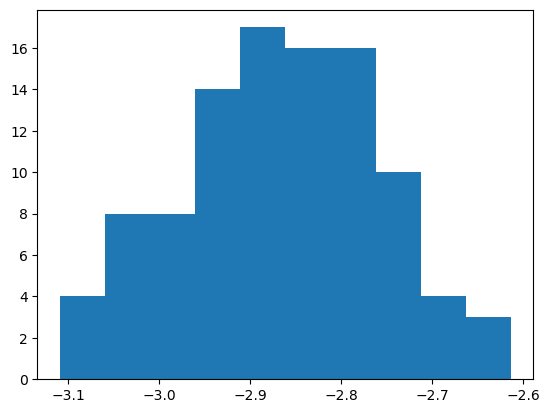

In [12]:
o = []
for i in range(100):
    with bmodel.sample() as model:
        o.append(model(c).log_prob(x)[0])

plt.hist(torch.stack(o).squeeze().cpu().detach().numpy())

# Training

Let's learn a bayesian flow over the classical moon example. We want to evaluate the uncertainty assigned by the flow to the density estimation in each point of the phasespace

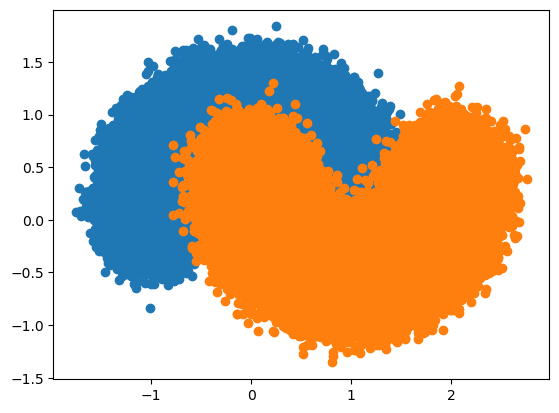

In [13]:
# Generate the two-moon dataset
Nevents = 500000
X, y = make_moons(n_samples=Nevents, noise=0.2, random_state=42)

# Separate the data points by class
X_class0 = X[y == 0]
X_class1 = X[y == 1]
plt.scatter(X_class0[:, 0], X_class0[:, 1])
plt.scatter(X_class1[:, 0], X_class1[:, 1])

In [14]:
x = torch.from_numpy(X).to(torch.float32)
c = torch.from_numpy(y).to(torch.float32).unsqueeze(-1)

In [15]:
model = zuko.flows.spline.NSF(
    features=2,
    context=1,
    bins=5,
    transforms=2,
    hidden_features=[32, 32],
)

bmodel = BayesianModel(model, init_logvar=-4.0)

### Training

In [16]:
opt = torch.optim.AdamW(bmodel.parameters(), lr=1e-4)
batch_size = 256
nepochs = 5

In [17]:
log = []
indices = np.arange(Nevents)
for e in range(nepochs):
    np.random.shuffle(indices)
    for i in range(Nevents // batch_size):
        x_i = x[indices[i * batch_size : (i + 1) * batch_size]]
        c_i = c[indices[i * batch_size : (i + 1) * batch_size]]
        # print(x.shape)
        with bmodel.sample() as smodel:
            # sample the model
            flow_loss = -smodel(c_i).log_prob(x_i).mean()

        # The KL divergence is automatically computed for all
        # Bayesian layers in the model when calling this method
        kl_loss = bmodel.kl_divergence(prior_std=1.0) / Nevents
        loss = flow_loss + kl_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        log.append((loss.item(), flow_loss.item(), kl_loss.item()))
        if i % 500 == 0:
            print(
                f"epoch={e}, step={i}, total loss: {loss.item():.3f}, flow loss:{flow_loss.item():.3f}, KL loss: {kl_loss.item():.3f}"
            )

epoch=0, step=0, total loss: 3.891, flow loss:3.878, KL loss: 0.013
epoch=0, step=500, total loss: 2.916, flow loss:2.903, KL loss: 0.013
epoch=0, step=1000, total loss: 2.576, flow loss:2.563, KL loss: 0.013
epoch=0, step=1500, total loss: 2.521, flow loss:2.509, KL loss: 0.013
epoch=1, step=0, total loss: 2.253, flow loss:2.240, KL loss: 0.013
epoch=1, step=500, total loss: 2.284, flow loss:2.272, KL loss: 0.013
epoch=1, step=1000, total loss: 1.977, flow loss:1.965, KL loss: 0.013
epoch=1, step=1500, total loss: 2.218, flow loss:2.205, KL loss: 0.013
epoch=2, step=0, total loss: 1.930, flow loss:1.917, KL loss: 0.013
epoch=2, step=500, total loss: 1.934, flow loss:1.921, KL loss: 0.013
epoch=2, step=1000, total loss: 1.950, flow loss:1.937, KL loss: 0.013
epoch=2, step=1500, total loss: 1.937, flow loss:1.924, KL loss: 0.013
epoch=3, step=0, total loss: 1.837, flow loss:1.825, KL loss: 0.013
epoch=3, step=500, total loss: 1.917, flow loss:1.904, KL loss: 0.013
epoch=3, step=1000, to

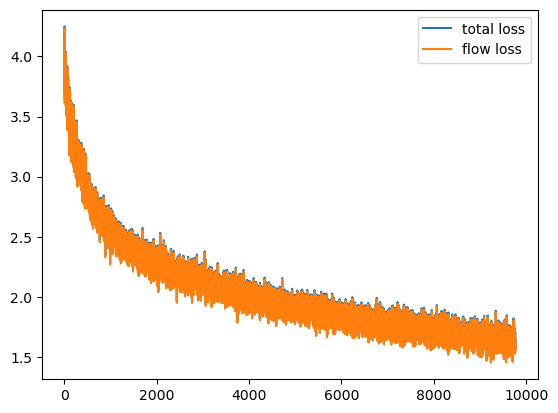

In [18]:
plt.plot([i[0] for i in log], label="total loss")
plt.plot([i[1] for i in log], label="flow loss")
plt.legend();

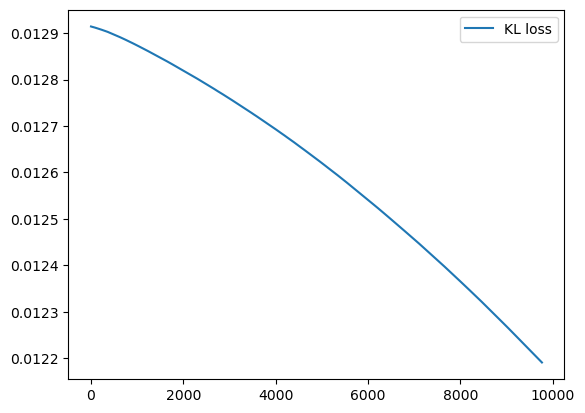

In [19]:
plt.plot([i[2] for i in log], label="KL loss")
plt.legend();

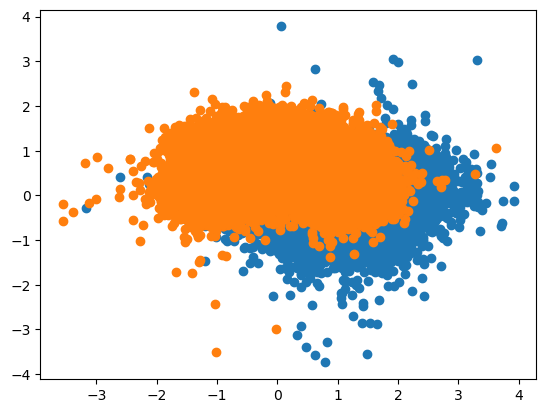

In [20]:
model.eval()
with torch.no_grad():
    with bmodel.sample() as smodel:
        samples_1 = smodel(torch.ones((20000, 1))).sample((1,)).cpu().squeeze().numpy()
        samples_2 = smodel(torch.zeros((20000, 1))).sample((1,)).cpu().squeeze().numpy()

plt.scatter(samples_1[:, 0], samples_1[:, 1])
plt.scatter(samples_2[:, 0], samples_2[:, 1])

In [21]:
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np


def profiled_histogram_2d(
    data_x,
    data_y,
    values,
    bins=10,
    range=None,
    title="2D Profiled Histogram",
    xlabel="X Bins",
    ylabel="Y Bins",
    cbar_label="Average Value",
    norm=None,
    vmax=2,
):
    # Calculate the 2D histogram with weights
    counts, x_edges, y_edges = np.histogram2d(
        data_x, data_y, bins=bins, range=range, weights=values
    )

    # Calculate the unweighted 2D histogram to handle empty bins correctly
    counts_unweighted, _, _ = np.histogram2d(data_x, data_y, bins=bins, range=range)

    # Calculate the mean value for each bin, handling empty bins
    bin_means = np.where(counts_unweighted > 0, counts / counts_unweighted, np.nan)

    # Plot the 2D profiled histogram
    # Use pcolormesh to create the 2D grid of bins with colors representing the mean values
    mesh = plt.pcolormesh(
        x_edges,
        y_edges,
        bin_means.T,  # Note the transpose (.T)
        cmap="viridis",  # You can choose a different colormap
        norm=matplotlib.colors.Normalize(vmin=np.nanmin(bin_means), vmax=vmax),
    )  # set the color scale
    plt.colorbar(mesh)

In [23]:
bmodel.eval()

x_test = x[(c == 1).squeeze(-1)][0:100000]
c_test = torch.ones((x_test.shape[0], 1))

densities = []
with torch.no_grad():
    for i in range(30):
        with bmodel.sample() as smodel:
            densities.append(smodel(c_test).log_prob(x_test))

D = torch.stack(densities, dim=1)
D_mean = D.mean(dim=1)
D_std = D.exp().std(dim=1)

Average probability density over the space

/tmp/ipykernel_639679/665269594.py:28: RuntimeWarning: invalid value encountered in divide
  bin_means = np.where(counts_unweighted > 0, counts / counts_unweighted, np.nan)


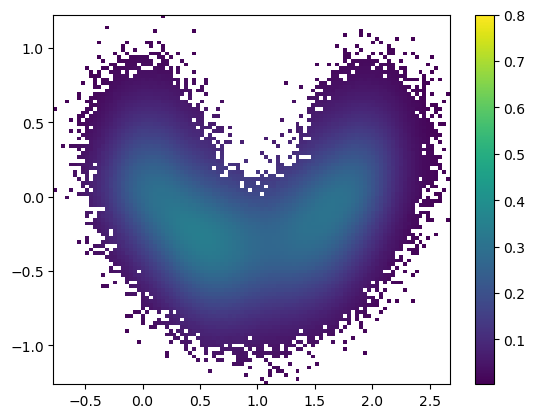

In [24]:
profiled_histogram_2d(
    x_test[:, 0].cpu().numpy(),
    x_test[:, 1].cpu().numpy(),
    D_mean.exp().cpu().numpy(),
    bins=100,
    vmax=0.8,
)

Average probability density uncertainty over the space

/tmp/ipykernel_639679/665269594.py:28: RuntimeWarning: invalid value encountered in divide
  bin_means = np.where(counts_unweighted > 0, counts / counts_unweighted, np.nan)


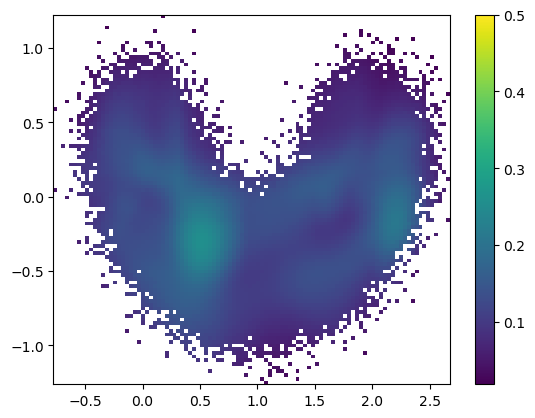

In [28]:
profiled_histogram_2d(
    x_test[:, 0].cpu().numpy(), x_test[:, 1].cpu().numpy(), D_std.cpu().numpy(), bins=100, vmax=0.5
)

Average relative uncertainty of the probability density in the phasespace

/tmp/ipykernel_639679/665269594.py:28: RuntimeWarning: invalid value encountered in divide
  bin_means = np.where(counts_unweighted > 0, counts / counts_unweighted, np.nan)


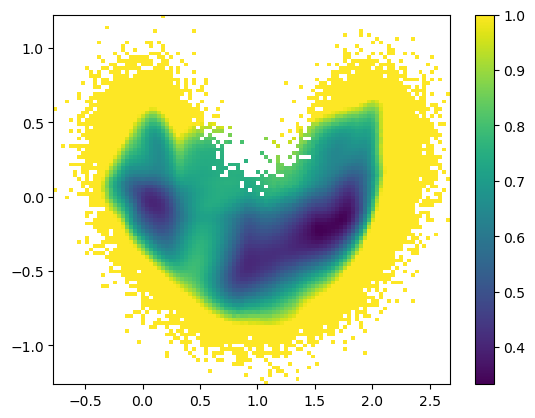

In [29]:
profiled_histogram_2d(
    x_test[:, 0].cpu().numpy(),
    x_test[:, 1].cpu().numpy(),
    D_std.cpu().numpy() / D_mean.exp().cpu().numpy(),
    bins=100,
    vmax=1,
)

# Looking at the parameters of the model

In [30]:
bmodel

BayesianModel(
  (base): NSF(
    (transform): LazyComposedTransform(
      (0): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=5)
        (order): [0, 1]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=3, out_features=32, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=32, out_features=32, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=32, out_features=28, bias=True)
        )
      )
      (1): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=5)
        (order): [1, 0]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=3, out_features=32, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=32, out_features=32, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=32, out_features=28, bias=True)
        )
      )
    )
    (base): UnconditionalDistribution(DiagNormal(loc: torch.Size([2]), scale: torch.Size([

In [31]:
logsvars = []
for n, p in bmodel.weight_logvars.items():
    logsvars.append(p.detach().cpu().numpy().flatten())

logsvars = np.concatenate(logsvars, axis=0)
logsvars

array([-3.0024607, -3.002121 , -4.242764 , ..., -3.0023165, -3.464562 ,
       -3.002079 ], shape=(4032,), dtype=float32)

Text(0.5, 0, 'Variance of the weight distribution')

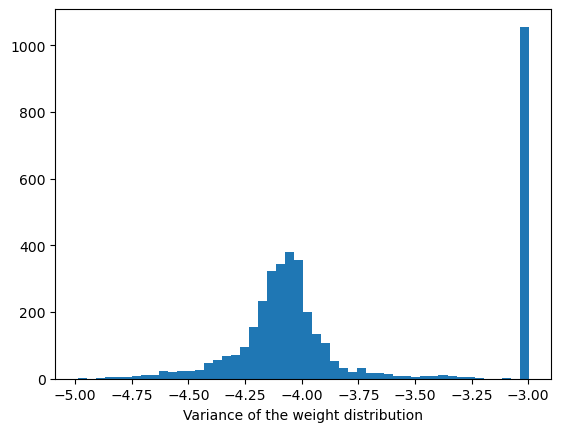

In [32]:
plt.hist(logsvars, bins=50)
plt.xlabel("Variance of the weight distribution")